# Teoria współbieżności

## Algorytm Eliminacji Gaussa z elementami współbieżności

### Maciej Wiśniewski grupa 9 środa 8.00

##### Cel zadania
Zadanie polegało na analizie algorytmu eliminacji Gaussa w kontekście teorii współbieżności oraz zaprojektowaniu jego współbieżnej implementacji. W tym celu zidentyfikowano niepodzielne czynności algorytmu, zbudowano alfabet w sensie teorii śladów, określono relacje zależności, a następnie wyznaczono graf zależności Diekerta oraz postać normalną Foaty. Na tej podstawie zaimplementowano współbieżny algorytm eliminacji Gaussa, działający poprawnie dla macierzy o dowolnym rozmiarze N.

In [52]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
import threading
import warnings
import copy

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(precision=3, suppress=True)

Na początek dodamy metody do obługi danych z plików

In [2]:
def process_file(input_file):
    if isinstance(input_file, str):
        with open(input_file, 'r', encoding='utf8') as f: text = f.read()
    else:
        text = input_file.read()
    
    lines = text.strip().split("\n")
    N = int(lines[0])
    
    matrix = [[None for _ in range(N)] for _ in range(N)]
    column = [[None] for _ in range(N)]
    
    for i in range(N):
        row_elems = lines[i + 1].split()
        for j in range(N):
            matrix[i][j] = float(row_elems[j])

    column_elems = lines[N + 1].split()
    for i in range(N): column[i][0] = float(column_elems[i])
    
    return N, matrix, column


def load_data_from_file(filename):
    try:
        N, matrix, column = process_file(filename)
        complemented_matrix = [row + col for row, col in zip(matrix, column)]
        
        return N, matrix, column, complemented_matrix  
    except FileNotFoundError:
        return None, None, None, None
    except Exception as e:
        return None, None, None, None

Przykładowe wywołanie

In [3]:
N, matrix, column, complemented_matrix = load_data_from_file('in.txt')

complemented_matrix = [row + col for row, col in zip(matrix, column)]

print("Macierz początkowa [A|b]:")
for i, row in enumerate(complemented_matrix):
    print(f"  [{' '.join([f'{x:7.2f}' for x in row])}]")

print(f"\nRozmiar: {N}x{N}")
print(f"Układ równań: Ax = b")

print("\nUkład równań:")
for i in range(N):
    eq = " + ".join([f"{matrix[i][j]:.1f}·x_{j+1}" for j in range(N)])
    print(f"  {eq} = {column[i][0]:.1f}")

Macierz początkowa [A|b]:
  [   2.00    1.00    3.00    6.00]
  [   4.00    3.00    8.00   15.00]
  [   6.00    5.00   16.00   27.00]

Rozmiar: 3x3
Układ równań: Ax = b

Układ równań:
  2.0·x_1 + 1.0·x_2 + 3.0·x_3 = 6.0
  4.0·x_1 + 3.0·x_2 + 8.0·x_3 = 15.0
  6.0·x_1 + 5.0·x_2 + 16.0·x_3 = 27.0


##### Współbieżna eliminacja Gaussa

W algorytmie współbieżnej eliminacji Gaussa wyróżniono trzy podstawowe typy niepodzielnych zadań obliczeniowych, oznaczone jako **A**, **B** oraz **C**, które stanowią podstawę dalszej analizy współbieżności algorytmu.

- **Aᵢ,ₖ** – zadanie polegające na wyznaczeniu mnożnika wykorzystywanego do eliminacji elementów znajdujących się pod elementem głównym macierzy. Mnożnik ten obliczany jest zgodnie ze wzorem:  
  *mₖ,ᵢ = Mₖ,ᵢ / Mᵢ,ᵢ*.

- **Bᵢ,ⱼ,ₖ** – zadanie polegające na pomnożeniu *j*-tego elementu wiersza *i* przez wcześniej obliczony mnożnik. Wynik tej operacji stanowi wartość pośrednią używaną w procesie eliminacji:  
  *nₖ,ᵢ = Mᵢ,ⱼ · mₖ,ᵢ*.

- **Cᵢ,ⱼ,ₖ** – zadanie realizujące właściwy krok eliminacji Gaussa, polegające na odjęciu obliczonej wartości pośredniej od odpowiedniego elementu wiersza *k*, zgodnie ze wzorem:  
  *Mₖ,ⱼ = Mₖ,ⱼ − nₖ,ᵢ*.

Powyższe zadania stanowią niepodzielne operacje obliczeniowe, na których oparto dalszą analizę relacji zależności oraz konstrukcję grafu współbieżności.

Na początku analizy zdefiniujemy klasę reprezentująca operacje


In [4]:
class GaussOperation: 
    def __init__(self):
        self.mki = {}  # mnożniki
        self.nki = {}  # pomnożone wartości
        self.history = []  # historia operacji
    
    def operation_A(self, M, i, k):
        """Oblicz mnożnik: m_ki = M[k,i] / M[i,i]"""
        key = f"{k}_{i}"
        self.mki[key] = M[k-1][i-1] / M[i-1][i-1]
        self.history.append(f"A({i},{k}): m_{{{k},{i}}} = {self.mki[key]:.3f}")
        return self.mki[key]
    
    def operation_B(self, M, i, j, k):
        """Pomnóż element: n_kij = M[i,j] * m_ki"""
        key_m = f"{k}_{i}"
        key_n = f"{k}_{i}_{j}"
        self.nki[key_n] = M[i-1][j-1] * self.mki[key_m]
        self.history.append(f"B({i},{j},{k}): n_{{{k},{i},{j}}} = {self.nki[key_n]:.3f}")
        return self.nki[key_n]
    
    def operation_C(self, M, i, j, k):
        """Odejmij: M[k,j] -= n_kij"""
        key = f"{k}_{i}_{j}"
        old_val = M[k-1][j-1]
        M[k-1][j-1] -= self.nki[key]
        self.history.append(f"C({i},{j},{k}): M[{k},{j}] = {old_val:.3f} - {self.nki[key]:.3f} = {M[k-1][j-1]:.3f}")


Następnie stworzymy metody do obsługi tych operacji i alfabetu

In [5]:
def get_alphabet(N):
    alphabet = []
    line_breaks = []
    
    for i in range(1, N):
        for k in range(i + 1, N + 1):
            alphabet.append({"oper": "A", "i": i, "k": k})
            for j in range(i, N + 2):
                alphabet.append({"oper": "B", "i": i, "j": j, "k": k})
                alphabet.append({"oper": "C", "i": i, "j": j, "k": k})
            
            if i < N - 1:
                if line_breaks: line_breaks.append(line_breaks[-1] + 2 * (N + 2 - i) + 1)
                else: line_breaks.append(2 * (N + 2 - i))
    
    return alphabet, line_breaks

def print_op(op): return f"A_({op['i']},{op['k']})" if op["oper"] == "A" else f"{op['oper']}_({op['i']},{op['j']},{op['k']})"

Potrzebujemy tez funckji do obliczania relacji zaleznosci i Postaci Normalnej Foaty FNF

In [6]:
def get_dependent_transactions(N):
    dependencies = []
    breaks = []

    def add_break(value):
        if breaks: breaks.append(breaks[-1] + value)
        else: breaks.append(value)

    for i in range(1, N):
        for k in range(i + 1, N + 1):
            opA = {"oper": "A", "i": i, "k": k}

            for j in range(i, N + 2):
                opB = {"oper": "B", "i": i, "j": j, "k": k}
                dependencies.append((opA, opB))
            add_break(N + 1 - i)
            for j in range(i, N + 2):
                opB = {"oper": "B", "i": i, "j": j, "k": k}
                opC = {"oper": "C", "i": i, "j": j, "k": k}
                dependencies.append((opB, opC))
            add_break(N + 2 - i)

    for i in range(2, N):
        for k in range(i + 1, N + 1):
            opA = {"oper": "A", "i": i, "k": k}
            dependencies.append(({"oper": "C", "i": i - 1, "j": i, "k": i}, opA))
            dependencies.append(({"oper": "C", "i": i - 1, "j": i, "k": k}, opA))

        add_break(N + 1 - i)
        for k in range(i + 1, N + 1):
            for j in range(i + 1, N + 2):
                dependencies.append(
                    ({"oper": "C", "i": i - 1, "j": j, "k": i},
                     {"oper": "B", "i": i, "j": j, "k": k}))

        add_break(N + 1 - i)

        for k in range(i + 1, N + 1):
            for j in range(i + 1, N + 2):
                dependencies.append(
                    ({"oper": "C", "i": i - 1, "j": j, "k": k},
                     {"oper": "C", "i": i, "j": j, "k": k}))

        if i < N - 1: add_break(N + 1 - i)

    return dependencies, breaks


In [7]:
def get_fnf(N):
    fnf = []
    
    for i in range(1, N):
        fnf.append([])
        for k in range(i + 1, N + 1): fnf[-1].append({"oper": "A", "i": i, "k": k})
        fnf.append([])
        for k in range(i + 1, N + 1):
            for j in range(i, N + 2):
                fnf[-1].append({"oper": "B", "i": i, "j": j, "k": k})
        fnf.append([])
        for k in range(i + 1, N + 1):
            for j in range(i, N + 2):
                fnf[-1].append({"oper": "C", "i": i, "j": j, "k": k})
    
    return fnf

Algorytm eliminacji Gaussa

In [8]:
def backward_substitution(eliminated_matrix, N):
    results = [0 for _ in range(N)]
    
    for i in range(N - 1, -1, -1):
        for j in range(i + 1, N):
            eliminated_matrix[i][N] -= eliminated_matrix[i][j] * results[j]
            eliminated_matrix[i][j] = 0.
        eliminated_matrix[i][N] /= eliminated_matrix[i][i]
        results[i] = eliminated_matrix[i][N]
        eliminated_matrix[i][i] = 1.
    
    return results

In [9]:
def parallel_gauss(matrix, fnf):
    M = [[el for el in row] for row in matrix]
    ops = GaussOperation()
    
    for foata_class in fnf:
        thread_list = []
        for task in foata_class:
            if task["oper"] == "A":
                thread = threading.Thread(target=ops.operation_A, args=(M, task["i"], task["k"]))
            elif task["oper"] == "B":
                thread = threading.Thread(target=ops.operation_B, args=(M, task["i"], task["j"], task["k"]))
            else: 
                thread = threading.Thread(target=ops.operation_C,args=(M, task["i"], task["j"], task["k"]))
            
            thread_list.append(thread)
        
        for thread in thread_list: thread.start()
        for thread in thread_list: thread.join()
    
    return M, ops

Mając zdefiniowane wszystkie metody możemy przejść do działania. Dla przykładu użyjemy danych z pliku *in.txt*

In [13]:
N, matrix, column, complemented_matrix = load_data_from_file('in.txt')

alphabet, line_breaks = get_alphabet(N)
print("Σ = {", end="")
for i, op in enumerate(alphabet):
    print(print_op(op), end="")
    if i < len(alphabet) - 1: print(", ", end="")
    if i in line_breaks:  print("\n     ", end="")

Σ = {A_(1,2), B_(1,1,2), C_(1,1,2), B_(1,2,2), C_(1,2,2), B_(1,3,2), C_(1,3,2), B_(1,4,2), C_(1,4,2), 
     A_(1,3), B_(1,1,3), C_(1,1,3), B_(1,2,3), C_(1,2,3), B_(1,3,3), C_(1,3,3), B_(1,4,3), C_(1,4,3), 
     A_(2,3), B_(2,2,3), C_(2,2,3), B_(2,3,3), C_(2,3,3), B_(2,4,3), C_(2,4,3)

In [16]:
dependent, dep_line_breaks = get_dependent_transactions(N)

print("D = sym{", end="")
for i, (dep1, dep2) in enumerate(dependent):
    print(f"({print_op(dep1)},{print_op(dep2)})", end="")
    if i < len(dependent) - 1:
        print(", ", end="")
        if i in dep_line_breaks:
            print("\n        ", end="")
print("}⁺ ∪ I_Σ\n")


D = sym{(A_(1,2),B_(1,1,2)), (A_(1,2),B_(1,2,2)), (A_(1,2),B_(1,3,2)), (A_(1,2),B_(1,4,2)), 
        (B_(1,1,2),C_(1,1,2)), (B_(1,2,2),C_(1,2,2)), (B_(1,3,2),C_(1,3,2)), (B_(1,4,2),C_(1,4,2)), 
        (A_(1,3),B_(1,1,3)), (A_(1,3),B_(1,2,3)), (A_(1,3),B_(1,3,3)), 
        (A_(1,3),B_(1,4,3)), (B_(1,1,3),C_(1,1,3)), (B_(1,2,3),C_(1,2,3)), (B_(1,3,3),C_(1,3,3)), 
        (B_(1,4,3),C_(1,4,3)), (A_(2,3),B_(2,2,3)), 
        (A_(2,3),B_(2,3,3)), (A_(2,3),B_(2,4,3)), (B_(2,2,3),C_(2,2,3)), 
        (B_(2,3,3),C_(2,3,3)), (B_(2,4,3),C_(2,4,3)), 
        (C_(1,2,2),A_(2,3)), (C_(1,2,3),A_(2,3)), 
        (C_(1,3,2),B_(2,3,3)), (C_(1,4,2),B_(2,4,3)), (C_(1,3,3),C_(2,3,3)), (C_(1,4,3),C_(2,4,3))}⁺ ∪ I_Σ



In [18]:
fnf = get_fnf(N)

print("FNF([w]) = ", end="")
for i, foata_class in enumerate(fnf):
    print("[", end="")
    for op in foata_class:
        print(print_op(op), end="")
    print("]", end="")
    if i % 2 == 1 and i < len(fnf) - 1:
        print("\n           ", end="")
print("\n")

# Potencjał równoległości
max_parallel = max(len(fc) for fc in fnf)
print(f"\nMaksymalne równoległość: {max_parallel} operacji jednocześnie")
print(f"Liczba kroków sekwencyjnych: {len(fnf)}")

FNF([w]) = [A_(1,2)A_(1,3)][B_(1,1,2)B_(1,2,2)B_(1,3,2)B_(1,4,2)B_(1,1,3)B_(1,2,3)B_(1,3,3)B_(1,4,3)]
           [C_(1,1,2)C_(1,2,2)C_(1,3,2)C_(1,4,2)C_(1,1,3)C_(1,2,3)C_(1,3,3)C_(1,4,3)][A_(2,3)]
           [B_(2,2,3)B_(2,3,3)B_(2,4,3)][C_(2,2,3)C_(2,3,3)C_(2,4,3)]


Maksymalne równoległość: 8 operacji jednocześnie
Liczba kroków sekwencyjnych: 6


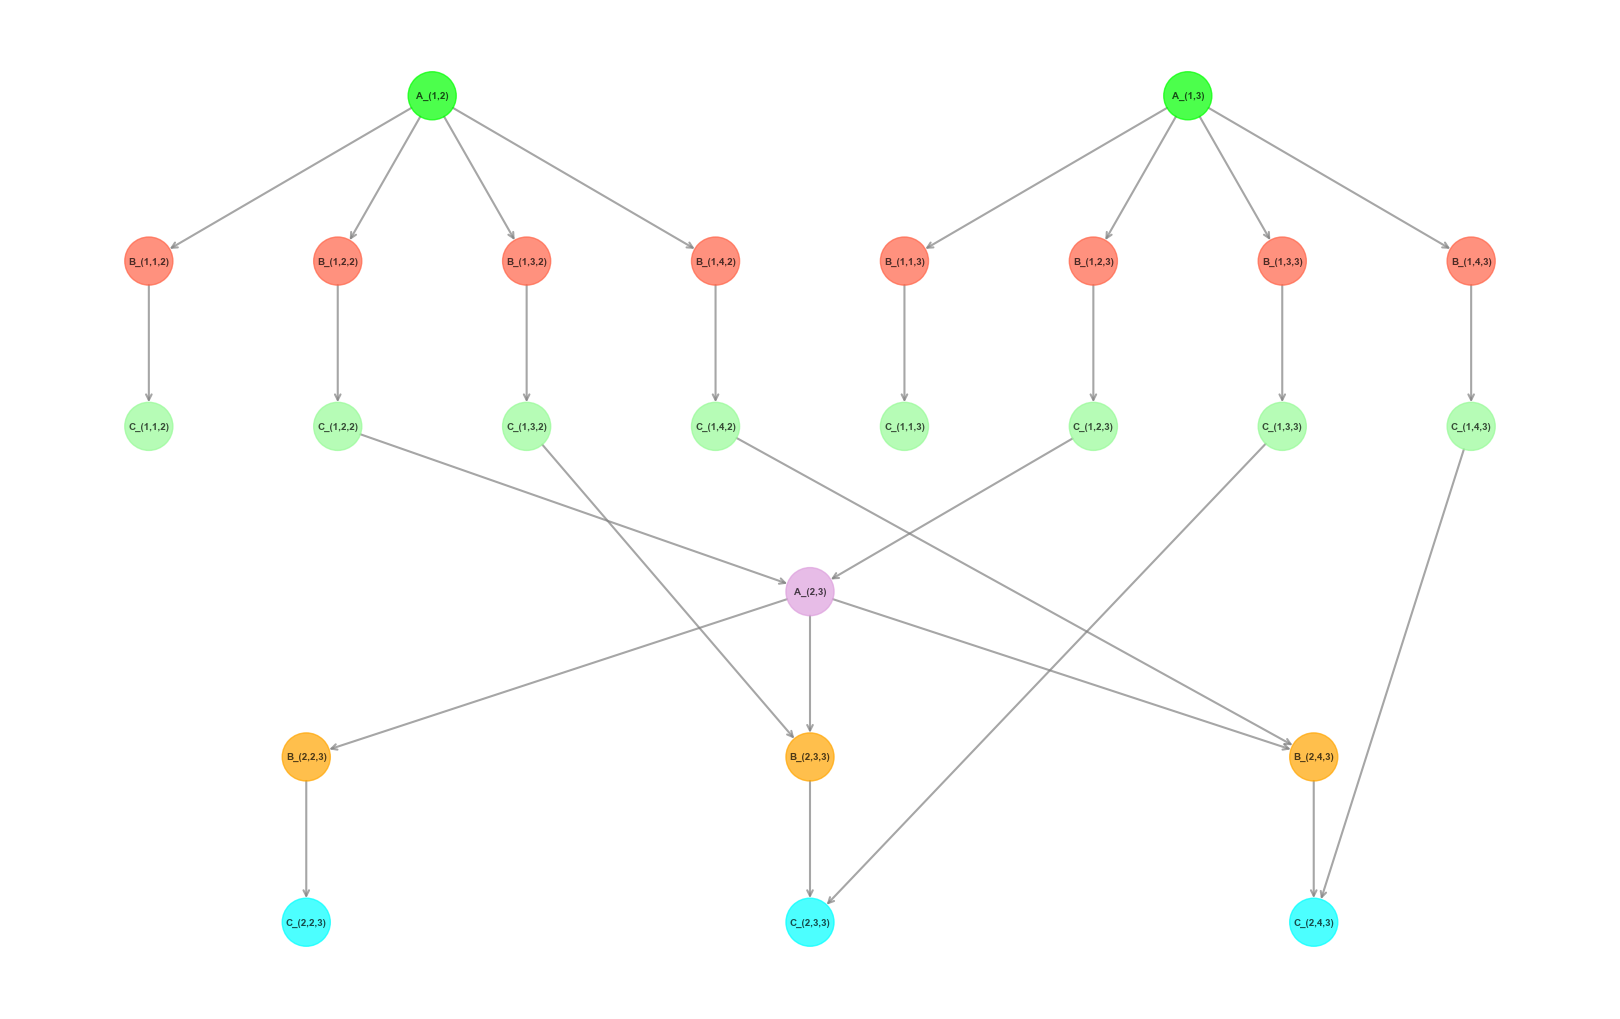

In [24]:
from matplotlib.patches import Patch
def visualize_diekert_graph(dependent, fnf, figsize=(16, 10)):
    G = nx.DiGraph()
    node_colors_palette = ["#00FF00", "#FF6347", "#98FB98", "#DDA0DD", "#FFA500", "#00FFFF", "#FF69B4", "#FFD700"]
    
    max_len = max(len(fc) for fc in fnf)
    positions = {}
    colors = []
    
    for i, foata_class in enumerate(fnf):
        shift_pos = max_len / len(foata_class) if len(foata_class) > 0 else 1
        base_pos = shift_pos / 2
        
        for j, op in enumerate(foata_class):
            node = print_op(op)
            G.add_node(node)
            positions[node] = [base_pos + j * shift_pos, len(fnf) - i]
            colors.append(node_colors_palette[i % len(node_colors_palette)])
    
    for dep1, dep2 in dependent:
        node1 = print_op(dep1)
        node2 = print_op(dep2)
        if node1 in G.nodes() and node2 in G.nodes(): G.add_edge(node1, node2)
    
    plt.figure(figsize=figsize)
    nx.draw(G, positions, node_color=colors, node_size=1200, 
            with_labels=True, font_size=7, font_weight='bold',
            arrows=True, arrowsize=10, arrowstyle='->', 
            edge_color='gray', width=1.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

visualize_diekert_graph(dependent, fnf)


Wykonujemy eliminacje gaussa dla przykladowej macierzy

In [27]:
complemented_copy = copy.deepcopy(complemented_matrix)

print("Macierz początkowa:")
for row in complemented_copy:
    print([f"{x:8.3f}" for x in row])

eliminated_matrix, ops = parallel_gauss(complemented_copy, fnf)

print(f"\nMacierz po eliminacji:")
for row in eliminated_matrix:
    print([f"{x:8.3f}" for x in row])


Macierz początkowa:
['   2.000', '   1.000', '   3.000', '   6.000']
['   4.000', '   3.000', '   8.000', '  15.000']
['   6.000', '   5.000', '  16.000', '  27.000']

Macierz po eliminacji:
['   2.000', '   1.000', '   3.000', '   6.000']
['   0.000', '   1.000', '   2.000', '   3.000']
['   0.000', '   0.000', '   3.000', '   3.000']


Wykonujemy podstawienie wsteczne

In [33]:
result_matrix = copy.deepcopy(eliminated_matrix)
results = backward_substitution(result_matrix, N)

for i, val in enumerate(results): print(f"x_{i+1}={val:4.3f}")

x_1=1.000
x_2=1.000
x_3=1.000


Weryfikacja poprawności otrzymanych wyników

In [35]:
verification = []
for i in range(N):
    sum_val = sum(matrix[i][j] * results[j] for j in range(N))
    verification.append(sum_val)
    expected = column[i][0]
    diff = abs(sum_val - expected)
    
    print(f"Równanie {i+1}: ", end="")
    print(" + ".join([f"{matrix[i][j]:.2f}*{results[j]:.3f}" for j in range(N)]), end="")
    print(f" = {sum_val:.3f} (oczekiwano: {expected:.3f}, błąd: {diff:.6f})")

max_error = max(abs(verification[i] - column[i][0]) for i in range(N))
print(f"\nMaksymalny błąd: {max_error:.10f}")

Równanie 1: 2.00*1.000 + 1.00*1.000 + 3.00*1.000 = 6.000 (oczekiwano: 6.000, błąd: 0.000000)
Równanie 2: 4.00*1.000 + 3.00*1.000 + 8.00*1.000 = 15.000 (oczekiwano: 15.000, błąd: 0.000000)
Równanie 3: 6.00*1.000 + 5.00*1.000 + 16.00*1.000 = 27.000 (oczekiwano: 27.000, błąd: 0.000000)

Maksymalny błąd: 0.0000000000


Analiza wydajności. Porównamy obliczenia sekwencyjne i równoległe

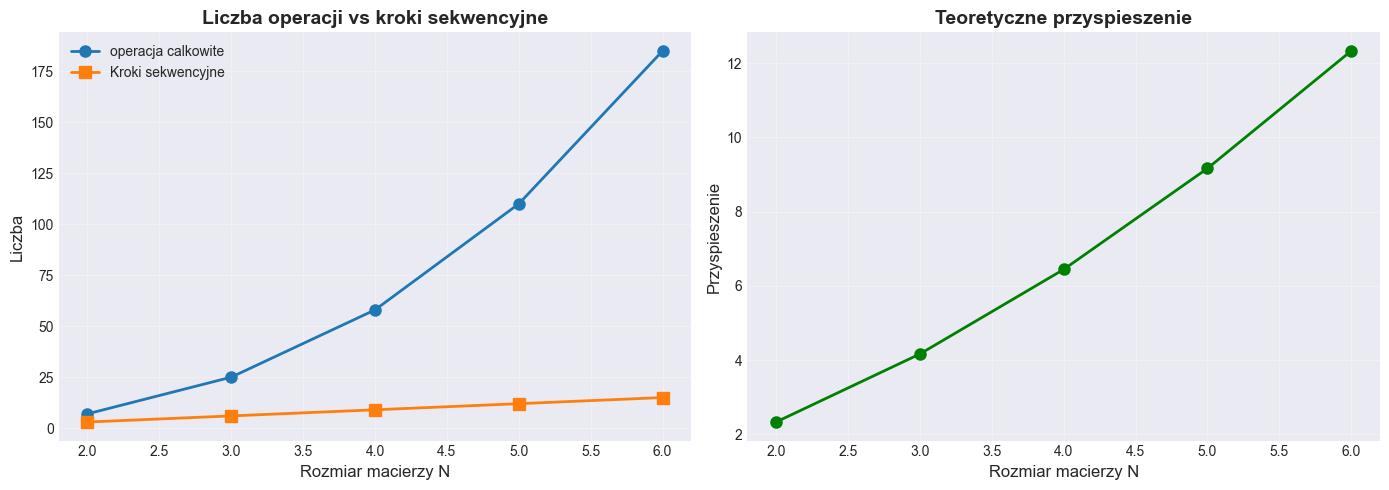

In [42]:
def compare_sizes(sizes=[2, 3, 4, 5, 6]):
    results = []
    for n in sizes:
        alphabet, _ = get_alphabet(n)
        fnf = get_fnf(n)
        
        results.append({'N': n,'total_ops': len(alphabet),'steps': len(fnf),
            'max_parallel': max(len(fc) for fc in fnf) if fnf else 0})

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    Ns = [r['N'] for r in results]
    ops = [r['total_ops'] for r in results]
    steps = [r['steps'] for r in results]
    
    ax1.plot(Ns, ops, 'o-', label='operacja calkowite', linewidth=2, markersize=8)
    ax1.plot(Ns, steps, 's-', label='Kroki sekwencyjne', linewidth=2, markersize=8)
    ax1.set_xlabel('Rozmiar macierzy N', fontsize=12)
    ax1.set_ylabel('Liczba', fontsize=12)
    ax1.set_title('Liczba operacji vs kroki sekwencyjne', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    speedups = [r['total_ops']/r['steps'] if r['steps'] > 0 else 0 for r in results]
    ax2.plot(Ns, speedups, 'o-', color='green', linewidth=2, markersize=8)
    ax2.set_xlabel('Rozmiar macierzy N', fontsize=12)
    ax2.set_ylabel('Przyspieszenie', fontsize=12)
    ax2.set_title('Teoretyczne przyspieszenie', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

compare_sizes()

Analiza zależności pomiędzy poszczególnymi operacjami

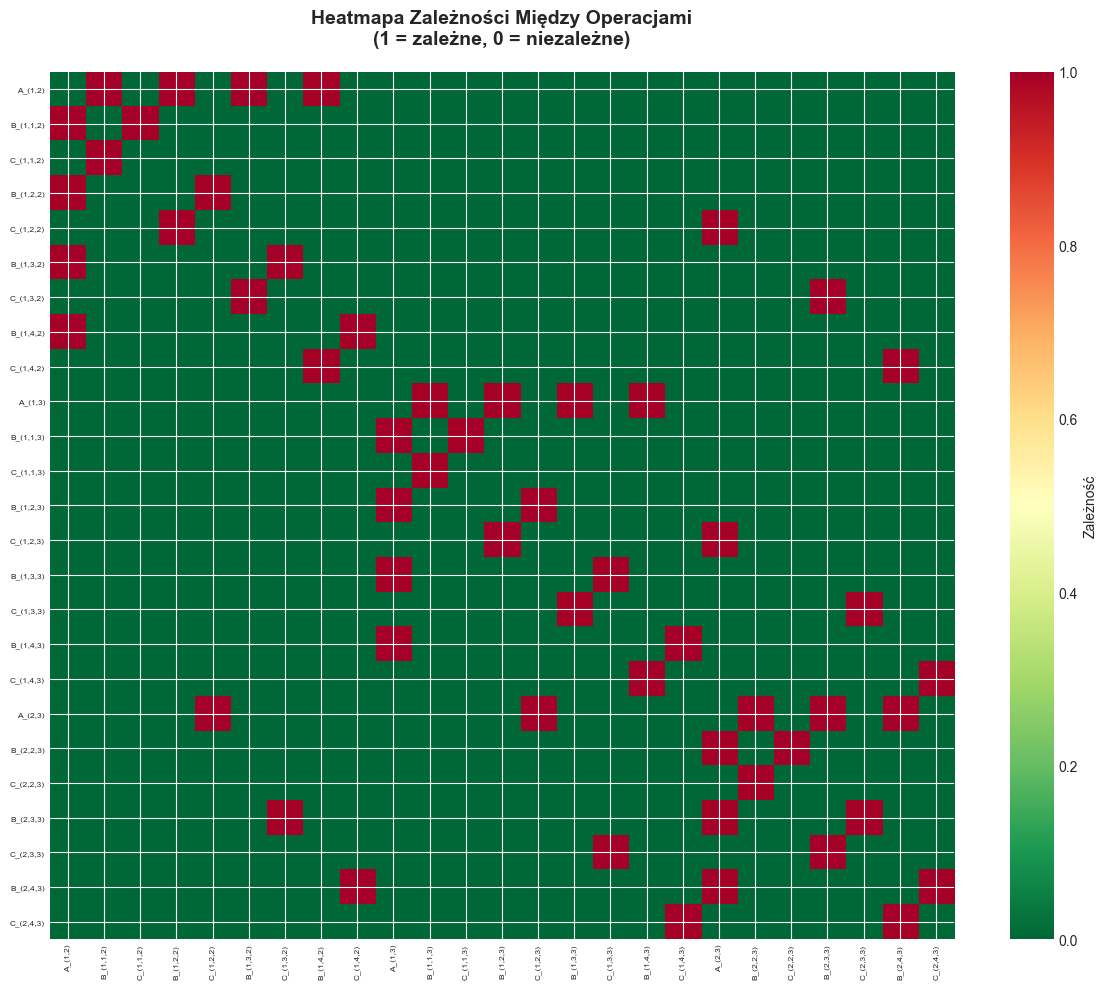

In [49]:
def visualize_dependency_heatmap(dependent, alphabet):
    op_to_idx = {print_op(op): i for i, op in enumerate(alphabet)}
    n = len(alphabet)
    dep_matrix = np.zeros((n, n))
    for dep1, dep2 in dependent:
        idx1 = op_to_idx.get(print_op(dep1))
        idx2 = op_to_idx.get(print_op(dep2))
        if idx1 is not None and idx2 is not None:
            dep_matrix[idx1][idx2] = 1
            dep_matrix[idx2][idx1] = 1 

    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(dep_matrix, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([print_op(op) for op in alphabet], rotation=90, fontsize=6)
    ax.set_yticklabels([print_op(op) for op in alphabet], fontsize=6)
    
    ax.set_title('Heatmapa Zależności Między Operacjami\n(1 = zależne, 0 = niezależne)',
                fontsize=14, fontweight='bold', pad=20)
    
    plt.colorbar(im, ax=ax, label='Zależność')
    plt.tight_layout()
    plt.show()
    total_pairs = n * (n - 1) / 2
    dependent_pairs = np.sum(dep_matrix) / 2
    independence_ratio = 1 - (dependent_pairs / total_pairs)

visualize_dependency_heatmap(dependent, alphabet)


Testowanie algorytmu dla innego przykladu

In [ ]:
N_big = 4
matrix_big = [
    [10.0, -1.0, 2.0, 0.0],
    [-1.0, 11.0, -1.0, 3.0],
    [2.0, -1.0, 10.0, -1.0],
    [0.0, 3.0, -1.0, 8.0]
]
column_big = [[6.0], [25.0], [-11.0], [15.0]]

complemented_big = [row + col for row, col in zip(matrix_big, column_big)]

print("\nMacierz początkowa [A|b]:")
for row in complemented_big:
    print([f"{x:7.2f}" for x in row])

alphabet_big, _ = get_alphabet(N_big)
fnf_big = get_fnf(N_big)
dependent_big, _ = get_dependent_transactions(N_big)

complemented_big_copy = copy.deepcopy(complemented_big)
eliminated_big, ops_big = parallel_gauss(complemented_big_copy, fnf_big)

print("\nMacierz po eliminacji:")
for row in eliminated_big:
    print([f"{x:7.3f}" for x in row])

result_big_matrix = copy.deepcopy(eliminated_big)
results_big = backward_substitution(result_big_matrix, N_big)

print(f"\nRozwiązanie:")
for i, val in enumerate(results_big):
    print(f"  x_{i+1} = {val:8.4f}")

print(f"\nWeryfikacja:")
for i in range(N_big):
    sum_val = sum(matrix_big[i][j] * results_big[j] for j in range(N_big))
    expected = column_big[i][0]
    diff = abs(sum_val - expected)
    print(f"  Równanie {i+1}: Ax = {sum_val:.4f}, b = {expected:.4f}, błąd = {diff:.6f}")



Macierz początkowa [A|b]:
['  10.00', '  -1.00', '   2.00', '   0.00', '   6.00']
['  -1.00', '  11.00', '  -1.00', '   3.00', '  25.00']
['   2.00', '  -1.00', '  10.00', '  -1.00', ' -11.00']
['   0.00', '   3.00', '  -1.00', '   8.00', '  15.00']

Macierz po eliminacji:
[' 10.000', ' -1.000', '  2.000', '  0.000', '  6.000']
['  0.000', ' 10.900', ' -0.800', '  3.000', ' 25.600']
['  0.000', '  0.000', '  9.541', ' -0.780', '-10.321']
['  0.000', ' -0.000', '  0.000', '  7.111', '  7.111']

Rozwiązanie:
  x_1 =   1.0000
  x_2 =   2.0000
  x_3 =  -1.0000
  x_4 =   1.0000

Weryfikacja:
  Równanie 1: Ax = 6.0000, b = 6.0000, błąd = 0.000000
  Równanie 2: Ax = 25.0000, b = 25.0000, błąd = 0.000000
  Równanie 3: Ax = -11.0000, b = -11.0000, błąd = 0.000000
  Równanie 4: Ax = 15.0000, b = 15.0000, błąd = 0.000000


### Podsumowanie 

Porównujac z wynikami otrzymanymi na ćwiczeniach oraz przy użyciu metod obliczeniowych, algorytm działa poprawnie.
Dzięki identyfikacji niezależnych operacji, ich wizualizacji i wyznaczeniu optymalnego harmonogramu równoległych obliczeń udało się znacznie przyspieszyć algorytm eliminacji Gaussa. 
Dla macierzy 3x3 otrzymaliśmy przyspieszenie 4.2x - to już jest dużo, a przyspiesznie dla większych macierzy rośnie - pokazaliśmy to na powyższych wykresach.